In [1]:
import pandas as pd
import numpy as np

import networkx as nx
import osmnx as ox

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Polygon
import matplotlib

from joypy import joyplot

from shapely import geometry

from geopandas.tools import sjoin
from geopandas import GeoDataFrame
import geopandas as gpd

from shapely import geometry
from shapely.geometry import Point
from shapely.geometry import Polygon

import math

from math import radians, cos, sin, asin, sqrt

print('loaded libraries')


#51.493599, -0.185418

loaded libraries


In [2]:
# Prunning Functions

from collections import defaultdict

def get_degs_freq_dict(G, i):
    """
    just to avoid unweildy code snippet
    G: Graph
    i: iteration (for debugging purpose)
    """
    degs = []
    node_color = []
    edge_color = []
    degs_freq_dict = defaultdict(lambda: [])
    
    for node_id in G.nodes:
        deg = len(G.edges(node_id))
        degs_freq_dict[deg] = np.append(degs_freq_dict[deg], node_id)
        if (deg <= 1):
            node_color.append('gray')
        else:
            node_color.append('gray')
    for e in G.edges:
        n1, n2 = e[0], e[1]
        if (n1 in degs_freq_dict[1]) or (n2 in degs_freq_dict[1]):
            edge_color.append('gray')
        else:
            edge_color.append('gray')
            
    return degs_freq_dict, node_color, edge_color

def get_deletable_nodes(G, i):
    """
    to filter out undeletable nodes 
    (because there are still some edges attached to it)
    G: Graph
    i: iteration (for debugging purpose)
    """
    node_colors = []
    deletable_nodes = []
    degs_freq_dict, _, _ = get_degs_freq_dict(G, i)
    
    # check if there exists some other nodes attach to it
    for node_id in degs_freq_dict[0]:
        deg_cnt = 0
        for e in G.edges:
            if (e[0] != node_id and e[1] == node_id):
                deg_cnt += 1
        # if only 1 node refer to it, we can still delete it
        if (deg_cnt <= 1):
            deletable_nodes.append(node_id)
    
    # check if there exists some other nodes attach to it
    for node_id in degs_freq_dict[1]:
        deg_cnt = 0
        for e in G.edges:
            if (e[0] != node_id and e[1] == node_id):
                deg_cnt += 1
        if (deg_cnt <= 1):
            deletable_nodes.append(node_id)
    
    for node_id in G:
        color = 'gray'
        if node_id in degs_freq_dict[0] or node_id in degs_freq_dict[1]:
            ### uncomment to which nodes we save them from getting deleted
            # color = 'blue'
            color = 'gray'
        if node_id in deletable_nodes:
            color = 'red'
        node_colors.append(color)
            
    return deletable_nodes, node_colors

def prune_culdasacs(G, show_last_result=True, verbose=False):
    i = 0 # iteration
    G_pruned = G.copy() # preserve original graph 
    if verbose:
        print('------- initial state -------')
        print(nx.info(G_pruned))
        print('-----------------------------')
    while(True):
        deletable_nodes, node_colors = get_deletable_nodes(G_pruned, i) 
        if len(deletable_nodes) > 0:
            if verbose:
                ox.plot_graph(G_pruned, node_color=node_colors, node_size=20, fig_height=5, node_alpha=0.8)
            G_pruned.remove_nodes_from(deletable_nodes)
            if verbose:
                print('---- [iter {}] removed {} nodes ----'.format(i, len(deletable_nodes)))
                print(nx.info(G_pruned))
                print('---------------------------------\n')
        else:
            if verbose:
                print('------------ finished -----------')
            if show_last_result:
                ox.plot_graph(G_pruned, node_size=20, fig_height=8, node_alpha=0.8)
            break
        i += 1
    return G_pruned


def get_bbox(point, dist=2000):
    """
    obtain the square area for the grid
    input: center of square (location point (lat,long))
    return: north, south, east, west coordinates
    """
    
    earth_radius = 6371000 #meters
    lat, lng = point
    
    delta_lat = (dist / earth_radius) * (180 / math.pi)
    delta_lng = (dist / earth_radius) * (180 / math.pi) / math.cos(lat * math.pi / 180)
    
    north  = lat + delta_lat
    south  = lat - delta_lat
    east = lng + delta_lng
    west = lng - delta_lng
    return north, south, east, west


# get tile Center

def createTileCenters(pathfile, gridx, gridy):
    """
    inputs gridx, gridy
    return: void
    function for creating tiles Center (points of interest)
    """
    tileCenter = {'gpsLatitude': [], 'gpsLongitude':[], 'geometry':[], 'code':[]}
    for i in range(len(gridx) - 1):

        cx = np.linspace(gridx[i], gridx[i+1], 3)

        for j in range(len(gridy)-1):
            cy = np.linspace(gridy[j], gridy[j+1], 3)
            #print('center tile', cy[1],  cx[1])
            tileCenter['gpsLatitude'].append(cy[1])
            tileCenter['gpsLongitude'].append(cx[1])
            tileCenter['geometry'].append(Point(cy[1],cx[1]))
            tileCenter['code'].append((i,j))
        
    tileCenter = pd.DataFrame(tileCenter)
    display(tileCenter.head())
    tileCenter.to_csv(pathfile + 'tileCenter.csv')
    print('createTileCentets: Done')
    
def calculateHaversine(lon1, lat1, lon2, lat2):
    """Calculate Haversine Distance"""
    EARTH_RADIUS = 6371

    lat1, lon1, lat2, lon2 = map(radians,
                                 [lat1,
                                  lon1,
                                  lat2,
                                  lon2])
    
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * asin(sqrt(a))
    
    return EARTH_RADIUS * c * 1000

def obtainGridDescription(gridx, gridy):
    """
    return void
    input gridx, gridy
    function to obtain description of the grid (double check)"""
        
    lon1 = gridx[0]
    lon2 = gridx[-1]

    lat1 = gridy[0]
    lat2 = gridy[-1]

    diagonal = calculateHaversine(lon1,lat1, lon2, lat2)

    lenx = calculateHaversine(lon1,lat1, lon2, lat1)
    leny = calculateHaversine(lon1,lat1, lon1, lat2)
    tilex = calculateHaversine(gridx[0],lat1, gridx[1], lat1)
    tiley = calculateHaversine(gridx[0],gridy[0], gridx[0], gridy[1])

    print('Grid X length:', round(lenx,3))
    print('Grid Y length:', round(leny,3))
    print('Grid diagonal length:', round(diagonal,3))

    print('\n   Tile X length', round(tilex,3))
    print('   Tile Y length', round(tiley,3))
    
    
def createPolyDataFrame(grid):
    
    """
    return (GEO) pd.DataDrame polyDataFrame 
    input: dict grid 
    Create DataFrame with Polygons
    """

    polyDataFrame = {'code' : [], 'geometry' : [],'grid' : []}

    for i in grid:

        point1 = (grid[i][0][0], grid[i][1][0])
        point2 = (grid[i][0][0], grid[i][1][1])
        point3 = (grid[i][0][1], grid[i][1][1])
        point4 = (grid[i][0][1], grid[i][1][0])

        poly = geometry.Polygon([point1,point2,point3,point4])

        polyDataFrame['code'].append(i)
        polyDataFrame['geometry'].append(poly)
        polyDataFrame['grid'].append(grid[i])

    polyDataFrame = pd.DataFrame(polyDataFrame)
    # convert to geodataframe
    polyDataFrame = GeoDataFrame(polyDataFrame, crs = "EPSG:4326")
    return polyDataFrame

def createMainGraph(poly, pathfile, prunning = False, network_type = 'walk'):
    """
    return osmnx multidigraph G
    inputs: polygon poly (squared box from grid)
            prunning (True if we want no culdesacs)
    function to crate Main Graph G
    """

    G_orig = ox.graph_from_polygon(polygon = poly , network_type = network_type)
    print(G_orig)
    
    fig, ax = plt.subplots(figsize=(6,6))
    ox.plot_graph(G_orig, edge_color='#808080', bgcolor='w', edge_alpha=0.2, node_color = "none", ax = ax, show = False)
    plt.title ("Graph Original")

    # Add Tolerances
    G_proj = ox.project_graph(G_orig)
    if prunning == True:
        #G = ox.consolidate_intersections(G_proj, rebuild_graph=True, tolerance=5, dead_ends=True)
        G = ox.consolidate_intersections(G_proj, rebuild_graph=True, tolerance=5, dead_ends=True)
    else:
        G = ox.consolidate_intersections(G_proj, rebuild_graph=True, tolerance=5, dead_ends=True)
    
    print(G)
    G_geo = ox.project_graph(G, to_crs='epsg:4326')
    G = ox.project_graph(G, to_crs='epsg:4326')

    
    filepath = pathfile + "squared-grid.graphml"
    
    fig, ax = plt.subplots(figsize=(6,6))
    ox.plot_graph(G, edge_color='#808080', bgcolor='w', edge_alpha=0.2, node_color = "none", ax = ax, show = False)
    plt.title ("Graph Consolidated")
    
    if prunning == True:
        G = prune_culdasacs(G, show_last_result=False, verbose=False)
        
        fig, ax = plt.subplots(figsize=(6,6))
        ox.plot_graph(G, edge_color='#808080', bgcolor='w', edge_alpha=0.2, node_color = "none", ax = ax, show = False)
        plt.title ("Pruned Graph")
        filepath = pathfile + "squared-grid-prunned.graphml"
    ox.save_graphml(G, filepath)
    return G, G_proj


def getGraphBasicStats(G_proj):
    """
    return void
    input G_proj
    """
    nodes_proj = ox.graph_to_gdfs(G_proj, edges=False)
    graph_area_m_G = nodes_proj.unary_union.convex_hull.area
    print("what sized area does our network cover in square meters?   ", graph_area_m_G)
    print(ox.basic_stats(G_proj, area=graph_area_m_G, clean_int_tol=15))
    
def checkForMissingNodes(G_orig, G):
    """
    check if there are any nodes without assigned polygon
    return void
    """
    nodes_orig = ox.graph_to_gdfs(G_orig, edges=False)

    missing_nodes = nodes_orig['x'].isna().sum()
    print('missing nodes total', missing_nodes)

    display(nodes_orig.head())
    G_geo = ox.project_graph(G, to_crs='epsg:4326')
    nodes = ox.graph_to_gdfs(G_geo, edges=False)

    display(nodes.head())
    edges = ox.graph_to_gdfs(G, nodes=False)    
    display(edges.head())
    missing_nodes = nodes['x'].isna().sum()
    print('missing nodes total', missing_nodes)
    print('Must be 0, since all nodes are assigned to a tile now')
    

def createNodesCSV(polyDataFrame, G, pathfile, route = 'walk', prunning = True):
    """
    return pd.DataFrame nodesInGrid
    inputs: OSMNX multigraph G, polygons dataframe, output path, walk or bike route, prunning true or false
    function to create nodesInGrid.csv (assign nodes to polygons)
    
    """
    crs = "EPSG:4326"
    nodes = ox.graph_to_gdfs(G, edges=False)
    nodes = GeoDataFrame(nodes).set_crs(crs, allow_override=True)
    #check which nodes are in the polygon area
    
    #print("nodes")
    display(nodes.head())
    #print("polyDataFrame")
    display(polyDataFrame.head())
    nodesInGrid = sjoin(nodes, polyDataFrame, predicate='within') 

    print('unique codes', len(nodesInGrid.code.unique()))

    suma = 0

    for i in sorted(nodesInGrid.code.unique()):
        nodesInGrid_ = nodesInGrid[nodesInGrid.code == i ]
        suma += len( nodesInGrid_.index)

    print('Important! Sum should match')
    print('Sum', suma, 'len index',len(nodesInGrid.index))

    nodesInGrid = nodesInGrid[["x","y","geometry","code","grid", "index_right"]] #,"weight" #"code2"
    equivalence = nodesInGrid[["code", "index_right"]]
    
    nodesInGrid.to_csv(pathfile + "nodesInGrid.csv")
    
    nodesInGrid_ = nodesInGrid.copy()
    nodesInGrid_ = nodesInGrid_[["x","y","index_right"]] #,"weight" #["x","y","code"]
    nodesInGrid_.reset_index(inplace=True)
    nodesInGrid_.rename(columns={'x': 'latitude', 'y': 'longitude', 'osmid':'id', 'index_right':'code'}, inplace=True) #'code2':'code'
    nodesInGrid_['id'] = nodesInGrid_['id'].astype(str) + '_'
    display(nodesInGrid_)
    title1 = pathfile + "nodesInGrid.csv"
    title2 = pathfile + "nodes-in-grid.csv"
    
    if prunning:
        title1 = pathfile + "nodesInGrid-pruned.csv"
        title2 = pathfile + "nodes-in-grid-pruned.csv"
    
    nodesInGrid.to_csv(title1, index = False)
    nodesInGrid_.to_csv(title2, index = False)
    return nodesInGrid_

def createCSVFiles(G, pathfile, network = "walk"):
    """
    create nodes and edges file, from osmnx format to csv compressed
    if network == walk , don't add repeated edges to csv (since it is an undirected graph)
    input: G, pathfile, network type
    output: nodes, edges
    """
    
    nodes = ox.graph_to_gdfs(G, edges=False)
    nodes.reset_index(inplace=True)
    nodes['osmid'] = nodes['osmid'].astype("string").astype(str) + '_'
    nodes = nodes[["osmid","y","x", "geometry"]] # dropping elevation too
    nodes.rename(columns={'osmid':'id'}, inplace=True)

    #display(nodes.head())

    edges = ox.graph_to_gdfs(G, nodes=False) 
    edges.reset_index(inplace=True)

    edges = edges[['u', 'v','length']]
    drop_rows = []
    multiedges = []
    n = 0
    for index, row in edges.iterrows():
        # Create graph without loops
        if row['u'] == row['v']:
            drop_rows.append(index)
        # For unidirected graph
        if network == "walk":
            if ([row['v'], row['u']] in multiedges) and (index not in drop_rows):
                drop_rows.append(index)
                n = n+1
        multiedges.append([row['u'], row['v']])
        
    print('total multiedges:', n)

    for i in reversed(drop_rows):
        edges.drop(i,axis= 0,inplace=True)
    #print('Dropped self loops',len(edges.index))

    edges['u'] = edges['u'].astype("string").astype(str) + '_'
    edges['v'] = edges['v'].astype("string").astype(str) + '_'
    edges.rename(columns={'u':'source','v':'target'}, inplace=True)
    display(edges.head())
    
    return(nodes, edges)

def createGraph(nodes, edges):
    """ 
    create nx graph (not used in the end)
    with preprocessed edges to avoid self loops*"""
    
    mG = nx.MultiDiGraph()
    
    for index, row in nodes.iterrows():
        mG.add_node(row['id'])
        
    for index, row in edges.iterrows():
        mG.add_edge(row["source"],row["target"])
        
    return(mG)


def createGridxy(north,south, east,west,n_tiles):
    """
    Segment main square into tiles
    input: north, south, east, west and number of tiles (+1)
    output = x-y coordinates for square and grid
    """
    # How many x squares
    gridx = np.linspace(east, west, n_tiles)
    #print(gridx)
    # How many y squares
    gridy = np.linspace(south, north, n_tiles)
    #print(gridy)

    grid = {}
    i = 0
    j = 0
    for x in range(len(gridx)-1):
        j = 0
        for y in range(len(gridy)-1):
            xx = [gridx[x],gridx[x+1]] #[gridx[0],gridx[-1]]
            yy = [gridy[y],gridy[y]]
            grid[i,j] = xx,[gridy[y],gridy[y+1]]
            j = j +1
        i = i +1
    
    return gridx, gridy, grid

## Define Grid center / area of interest

### Define grid_size and n_tiles

In [3]:
# grid size / 2 
# (that is to say, we will find the box the the grid_size you enter + location in the 4 directions)
# So 2500 would become a grid size of 5000 from north to south and 5000 from east to west.

grid_size = 3250

# number of desired tiles + 1
n_tiles = 61

location_point = (51.498732, -0.191946) # version for 8km grid

location_point = (51.490938, -0.196054) # version for 6.5 km grid <------ current center



### Important! Define Network Type and whether you want prunning or not 

In [4]:
# define network type
network_type = 'walk'
# prunned graph?
prunning = True
# path to save files
pathfile = "./data/ProcessedGraphs/6500/walk_p"


## Create Grid

In [5]:


north, south, east, west = get_bbox(location_point, dist = grid_size)
print(north,south,east,west)
print('------------------------------')
gridx, gridy, grid = createGridxy(north,south, east,west,n_tiles)
createTileCenters(pathfile, gridx, gridy)
polyDataFrame = createPolyDataFrame(grid)
#display(polyDataFrame.head())
print("Number of tiles:" ,len(polyDataFrame.index))

51.52016595219236 51.46171004780764 -0.1491119035287124 -0.24299609647128761
------------------------------


,gpsLatitude,gpsLongitude,geometry,code
0,51.462197,-0.149894,POINT (51.46219718034418 -0.1498942718032339),"(0, 0)"
1,51.463171,-0.149894,POINT (51.46317144541726 -0.1498942718032339),"(0, 1)"
2,51.464146,-0.149894,POINT (51.46414571049034 -0.1498942718032339),"(0, 2)"
3,51.465120,-0.149894,POINT (51.46511997556342 -0.1498942718032339),"(0, 3)"
4,51.466094,-0.149894,POINT (51.466094240636494 -0.1498942718032339),"(0, 4)"


createTileCentets: Done
Number of tiles: 3600


## Create Graph from squared grid

polyLimits POLYGON ((-0.1491119035287124 51.52016595219236, -0.2429960964712876 51.52016595219236, -0.2429960964712876 51.46171004780764, -0.1491119035287124 51.46171004780764, -0.1491119035287124 51.52016595219236))


/Users/madesant/opt/miniconda3/envs/ox/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/madesant/opt/miniconda3/envs/ox/lib/python3.11/site-packages/shapely/set_operations.py:340: RuntimeWarning: invalid value encountered in union
  return lib.union(a, b, **kwargs)
/Users/madesant/opt/miniconda3/envs/ox/lib/python3.11/site-packages/shapely/set_operations.py:340: RuntimeWarning: invalid value encountered in union
  return lib.union(a, b, **kwargs)


MultiDiGraph with 19818 nodes and 53194 edges


/Users/madesant/opt/miniconda3/envs/ox/lib/python3.11/site-packages/shapely/set_operations.py:426: RuntimeWarning: invalid value encountered in unary_union
  return lib.unary_union(collections, **kwargs)


MultiDiGraph with 14217 nodes and 41306 edges
MultiDiGraph with 10502 nodes and 33876 edges


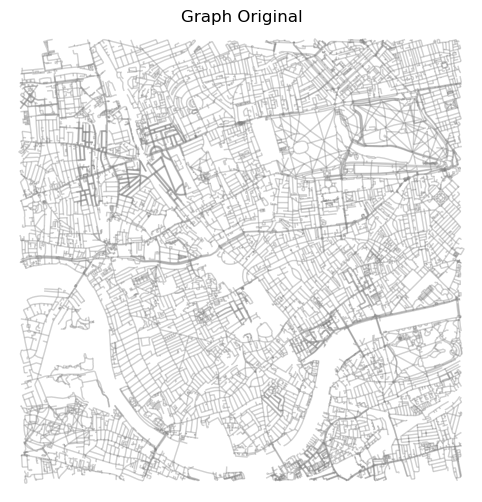

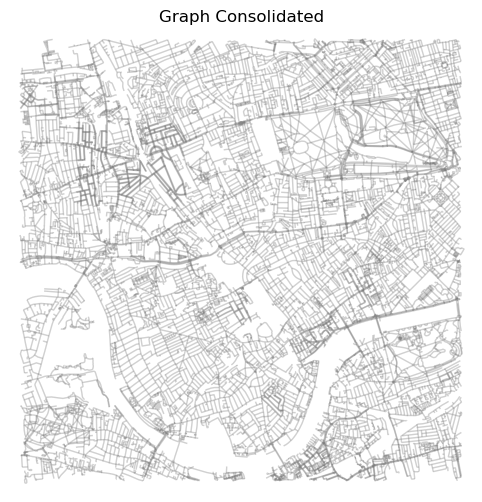

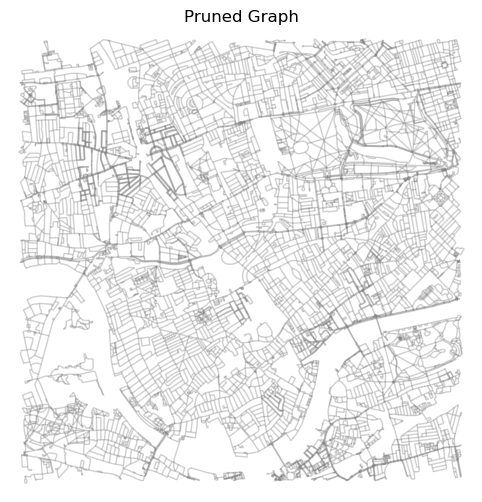

In [6]:
point1 = (east, north)
point2 = (west, north)
point3 = (west, south)
point4 = (east, south)
poly = geometry.Polygon([point1,point2,point3,point4])
print("polyLimits", poly)

G, G_proj = createMainGraph(poly,pathfile, prunning, network_type)
print(G)

## Obtain Nodes in Grid


In [7]:
NodesInGrid = createNodesCSV(polyDataFrame, G, pathfile, route = network_type, prunning = prunning)

,osmid_original,y,x,street_count,lon,lat,highway,geometry
osmid,,,,,,,,
0,101995,51.519974,-0.151786,3,-0.151786,51.519974,NaN,POINT (-0.15179 51.51997)
1,1619500464,51.519850,-0.151769,3,-0.151769,51.519850,NaN,POINT (-0.15177 51.51985)
2,"[1619464655, 668347988]",51.520008,-0.151018,0,NaN,NaN,NaN,POINT (-0.15102 51.52001)
10580,"[1667118119, 3588620011, 1667118116, 3588620005]",51.519781,-0.152574,0,NaN,NaN,NaN,POINT (-0.15257 51.51978)
4,6371330219,51.518738,-0.151633,3,-0.151633,51.518738,crossing,POINT (-0.15163 51.51874)


,code,geometry,grid
0,"(0, 0)","POLYGON ((-0.14911 51.46171, -0.14911 51.46268...","([-0.1491119035287124, -0.15067664007775533], ..."
1,"(0, 1)","POLYGON ((-0.14911 51.46268, -0.14911 51.46366...","([-0.1491119035287124, -0.15067664007775533], ..."
2,"(0, 2)","POLYGON ((-0.14911 51.46366, -0.14911 51.46463...","([-0.1491119035287124, -0.15067664007775533], ..."
3,"(0, 3)","POLYGON ((-0.14911 51.46463, -0.14911 51.46561...","([-0.1491119035287124, -0.15067664007775533], ..."
4,"(0, 4)","POLYGON ((-0.14911 51.46561, -0.14911 51.46658...","([-0.1491119035287124, -0.15067664007775533], ..."


unique codes 2883
Important! Sum should match
Sum 10502 len index 10502


,id,latitude,longitude,code
0,0_,-0.151786,51.519974,119
1,1_,-0.151769,51.519850,119
2,2_,-0.151018,51.520008,119
3,10576_,-0.150965,51.519430,119
4,10580_,-0.152574,51.519781,179
...,...,...,...,...
10497,13700_,-0.222445,51.511875,2811
10498,13902_,-0.221888,51.511445,2811
10499,13701_,-0.222531,51.511975,2811
10500,13900_,-0.221936,51.511750,2811


## Create Nodes & Edges Files


In [8]:
nodes, edges = createCSVFiles(G, pathfile, network_type)

#nodes.to_csv('./data/square-grid-nodes.csv', index = False) # For java, only the nodes-in-grid file is needed
edges.to_csv(pathfile + 'square-grid-edges.csv', index = False)

print(len(edges.index))

# Important! If you want to create a simple nx graph uncomment
# mG = createGraph(nodes, edges) 
# print('Graph', mG)


total multiedges: 16890


,source,target,length
0,0_,1_,13.882000
1,0_,2_,53.442233
2,1_,10580_,56.670799
4,1_,4_,123.961000
5,2_,10576_,66.528851


16890


## Obtain Geometries File

In [9]:
fgrid = polyDataFrame.copy()
fgrid['code'] = np.linspace(0, len(fgrid.index)-1, len(fgrid.index), dtype=int)
fgrid = fgrid[['code','geometry']]
#display(fgrid.head())
print('grid data (grid) [just to avoid rebuilding polygon]')
fgrid.to_csv(pathfile + "grid.csv", index = False)
# -------------------------------------
fgrid = pd.read_csv(pathfile + "grid.csv")
display(fgrid.head())

# The previous line creates a geopandas dataframe with the polygon option, 
# Java cannot read that but it also cannot read the tuples, so convert that to a readable java string 
#    [cont] by adding an underscore between pair of coordinates for polygon.

fgrid['geometry'] = fgrid['geometry'].str.replace('POLYGON','').str.replace('(','').str.replace(')','').str.replace(',','_')
print('Simplified grid data (grid-geom)')
display(fgrid.head())
fgrid.to_csv(pathfile + "grid-geom.csv", index = False)

print('done')

grid data (grid) [just to avoid rebuilding polygon]


,code,geometry
0,0,POLYGON ((-0.1491119035287124 51.4617100478076...
1,1,POLYGON ((-0.1491119035287124 51.4626843128807...
2,2,POLYGON ((-0.1491119035287124 51.4636585779538...
3,3,POLYGON ((-0.1491119035287124 51.4646328430268...
4,4,POLYGON ((-0.1491119035287124 51.4656071080999...


Simplified grid data (grid-geom)


,code,geometry
0,0,-0.1491119035287124 51.46171004780764_ -0.149...
1,1,-0.1491119035287124 51.46268431288072_ -0.149...
2,2,-0.1491119035287124 51.4636585779538_ -0.1491...
3,3,-0.1491119035287124 51.46463284302688_ -0.149...
4,4,-0.1491119035287124 51.46560710809996_ -0.149...


done


IMPORTANT! The files actually needed for the mobile app from this process are the
grid-geom.csv
and for each graph: grid-edges.csv and nodes-in-grid.csv

In [10]:
error
# just to stop the run all command

NameError: name 'error' is not defined

## The Next lines of co

## Code for some plots in the report

In [ ]:
"""# types info regarding each graph for plot

import pandas as pd

prunning = [False, False,True, True ]
network = ['walk','bike','walk', 'bike']
graphInfo = {'nodes':[],'edges':[],'graph':[],'dist':[]}
distances = [1500, 2000,2500,3000,3500,4000, 4500, 5000];

for dist in distances:
    
    
    north, south, east, west = get_bbox(location_point, dist = dist)

    gridx, gridy, grid = createGridxy(north,south, east,west,n_tiles)
    createTileCenters(gridx, gridy)
    polyDataFrame = createPolyDataFrame(grid)
    #display(polyDataFrame.head())
    
    point1 = (east, north)
    point2 = (west, north)
    point3 = (west, south)
    point4 = (east, south)
    
    poly = geometry.Polygon([point1,point2,point3,point4])

    for i in range(4):
        
        
        print(network[i], prunning[i])
        G, G_proj = createMainGraph(poly, prunning[i],network[i])
        prunningStr = 'noPrunning'
        if prunning[i]:
            prunningStr = 'prunning'
        nodes = ox.graph_to_gdfs(G, edges=False)
        edges = ox.graph_to_gdfs(G, nodes=False)

        print('Nodes', len(nodes))
        print('Edges', len(edges))
        graphInfo['nodes'].append(len(nodes))
        graphInfo['edges'].append(len(edges))
        graphInfo['graph'].append(network[i] +'_'+prunningStr)
        graphInfo['dist'].append(dist*2)
    #print(G)

graphInfo = pd.DataFrame(graphInfo)
graphInfo.to_csv('graphInfo.csv')
display(graphInfo.head())#"""
#graphInfo.to_csv('graphInfo.csv')
"""

In [ ]:

# plot info about graphs
import pandas as pd


#graphInfo.to_csv('graphInfo.csv')

graphInfo = pd.read_csv('graphInfo.csv')

plt.rc('axes', axisbelow=True)

labels = ['Walking Network', 'Cycling Network']
i_s = ['walk_noPrunning', 'bike_noPrunning']
colors = ['salmon','#041E42']
n = 0


for i in i_s:
    df_ = graphInfo[graphInfo['graph'] == i]
     
    plt.plot(df_['dist'], df_['nodes'], label = labels[n], color = colors[n])
    plt.scatter(df_['dist'], df_['nodes'],color = colors[n])
    n = n+1
plt.title('Number of nodes vs Graph with various grid sizes')
plt.ylabel('Number of Nodes')
plt.xlabel('Grid size [km$^2$]')

xticks_ = []
x = []
for i in df_['dist'].unique():
    x.append(i)
    xticks_.append(int(i**2/1000000))

plt.xticks(x, xticks_)
plt.legend()
plt.grid()
plt.show()

n = 0
for i in i_s:
    df_ = graphInfo[graphInfo['graph'] == i]
    plt.plot(df_['dist'], df_['edges'], label = labels[n],color = colors[n])
    plt.scatter(df_['dist'], df_['edges'],color = colors[n])
    n = n+1
plt.title('Number of edges vs Graph with various grid sizes')
plt.ylabel('Number of Edges')
plt.xlabel('Grid size [km$^2$]')
plt.xticks(x, xticks_)
plt.legend()
plt.grid(zorder=0)
plt.show()

In [ ]:
import pandas as pd


#graphInfo.to_csv('graphInfo.csv')

graphInfo = pd.read_csv('graphInfo.csv')

plt.rc('axes', axisbelow=True)

labels = ['Walking Network', 'Cycling Network']
i_s = ['walk_noPrunning', 'bike_noPrunning']
colors = ['salmon','#041E42']
n = 0

fig, ax = plt.subplots(ncols=2, figsize=(12,6))

xticks_ = []
x = []
for i in df_['dist'].unique():
    x.append(i)
    xticks_.append(int(i**2/1000000))
    
for i in i_s:
    df_ = graphInfo[graphInfo['graph'] == i]
     
    ax[0].plot(df_['dist'], df_['nodes'], label = labels[n], color = colors[n])
    ax[0].scatter(df_['dist'], df_['nodes'],color = colors[n])
    n = n+1
#ax[0].title('Number of nodes vs Graph with various grid sizes')
ax[0].set_ylabel('Number of Nodes')
ax[0].set_xlabel('Grid size [km$^2$]')

ax[0].set_xticks(x, xticks_)
ax[0].grid(True)


plt.xticks(x, xticks_)
#plt.legend()



n = 0
for i in i_s:
    df_ = graphInfo[graphInfo['graph'] == i]
    ax[1].plot(df_['dist'], df_['edges'], label = labels[n],color = colors[n])
    ax[1].scatter(df_['dist'], df_['edges'],color = colors[n])
    n = n+1
#plt.title('Number of edges vs Graph with various grid sizes')
ax[1].set_ylabel('Number of Edges')
ax[1].set_xlabel('Grid size [km$^2$]')
ax[1].grid(True)

ax[1].get_yaxis().set_major_formatter(
matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax[0].get_yaxis().set_major_formatter(
matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

#ax[1].set_xticks(x, xticks_)
#plt.xticks(x, xticks_)
#ax[1].set_legend()

ax[1].legend(loc="upper left")
ax[0].legend(loc="upper left")
plt.savefig('comparisonGridSize.png')
plt.show()

In [ ]:

place_name = 'Kensington and Chelsea, Greater London, UK'

G = ox.graph_from_place(place_name, network_type = "walk")

Gp = prune_culdasacs(G, show_last_result=False, verbose=False)



location_point = (51.497705, -0.175423)

north, south, east, west = get_bbox(location_point, dist = 1000)

point1 = (east, north)
point2 = (west, north)
point3 = (west, south)
point4 = (east, south)
poly = geometry.Polygon([point1,point2,point3,point4])
G = ox.graph_from_polygon(polygon = poly , network_type = 'walk')
Gp = prune_culdasacs(G, show_last_result=False, verbose=False)

#'#041E42'
        
#fig, ax = plt.subplots(figsize=(6,6))

fig, ax = plt.subplots(ncols=2, figsize=(12,6))

ec = ["gray" if edge in Gp.edges else "salmon" for edge in G.edges]

ox.plot_graph(G, edge_color=ec, bgcolor='w', edge_alpha=0.75, node_color = "none", ax = ax[0], show = False)

#'#041E42'

ox.plot_graph(Gp, edge_color='gray', bgcolor='w', edge_alpha=0.85, 
              node_color = "none", ax = ax[1], show = False)

plt.tight_layout()
plt.savefig('./data/prunnedGraphEx.png')  

plt.show()

print('done')

In [ ]:
place_name = 'Kensington and Chelsea, Greater London, UK'

#G = ox.graph_from_place(place_name, network_type = "walk")

#Gp = prune_culdasacs(G, show_last_result=False, verbose=False)



location_point = (51.497705, -0.175423)

north, south, east, west = get_bbox(location_point, dist = 1000)

point1 = (east, north)
point2 = (west, north)
point3 = (west, south)
point4 = (east, south)
poly = geometry.Polygon([point1,point2,point3,point4])
G = ox.graph_from_polygon(polygon = poly , network_type = 'walk')
Gb = ox.graph_from_polygon(polygon = poly , network_type = 'bike')
        
#fig, ax = plt.subplots(figsize=(6,6))

fig, ax = plt.subplots(ncols=2, figsize=(16,8))

ox.plot_graph(G, edge_color='grey', bgcolor='w', edge_alpha=0.85, node_color = "none", ax = ax[0], show = False)
#ox.plot_graph(G, edge_color='steelblue', bgcolor='w', edge_alpha=1, node_color = "none", ax = ax, show = False)
    
#plt.show()
#
#fig, ax = plt.subplots(figsize=(6,6))


edge_colors = []

# Iterate over each edge in the graph
for u, v, k, data in Gb.edges(keys=True, data=True):
    # Check if the edge is one-way
    if data["oneway"]:
        edge_colors.append("#F05E16")  # Color one-way edges red
    else:
        edge_colors.append('grey')  # Color two-way edges blue

# Plot the graph with colored edges
ox.plot_graph(Gb, edge_color=edge_colors, bgcolor='w', edge_alpha=0.85, 
              node_color='none',node_size = 0,
              ax = ax[1],
              show=False, close=False)


#ox.plot_graph(Gb, edge_color='#808080', bgcolor='w', edge_alpha=1, node_color = "none", ax = ax[1], show = False)
plt.tight_layout()
plt.savefig('./data/CyclingWalkingGraphs.png')  

plt.show()

In [ ]:
location_point = (51.497705, -0.175423)

north, south, east, west = get_bbox(location_point, dist = 500)

point1 = (east, north)
point2 = (west, north)
point3 = (west, south)
point4 = (east, south)
poly = geometry.Polygon([point1,point2,point3,point4])


Gb_orig = ox.graph_from_polygon(polygon = poly , network_type = 'walk')
Gb_orig = ox.graph_from_polygon(polygon = poly , network_type = 'bike')


Gb = ox.project_graph(Gb_orig)
Gb = ox.consolidate_intersections(Gb, rebuild_graph=True, tolerance=5, dead_ends=True)
    
#print(G)
Gb = ox.project_graph(Gb, to_crs='epsg:4326')

       
nodes = ox.graph_to_gdfs(Gb, edges=False)


fig, ax = plt.subplots(figsize=(12,8))

ox.plot_graph(Gb_orig, node_color='white',
                       bgcolor='w', edge_alpha=0.25, edge_color = 'grey',
                       node_alpha = 1, node_size = 35, node_edgecolor='grey',
                       ax = ax, show =False)

#fig, ax = ox.plot_graph(Gb_orig, node_color='none',
#                       bgcolor='w', edge_alpha=0.85, 
#                       node_alpha = 0.75, node_size = 0,
#                       ax = ax, show =False)
#'#041E42'
nc = ["white" if node in Gb_orig.nodes else "salmon" for node in nodes["osmid_original"]]
ns = [0 if node in Gb_orig.nodes else 1005 for node in nodes["osmid_original"]]
ec = ["none" if node in Gb_orig.nodes else '#041E42' for node in nodes["osmid_original"]]

ox.plot_graph(Gb, node_color=nc,
              bgcolor='w', edge_alpha=0.25, edge_color = 'grey',
              node_alpha = 0.50, node_size = ns, node_edgecolor=ec,
              ax = ax, show = False)
plt.savefig('NodesMerge.png')
#plt.show()
#nc = ["white" if node in Gb_orig.nodes else "salmon" for node in nodes["osmid_original"]]
print('done')
plt.tight_layout()

left, right = plt.xlim()
print(left,right)
up, down = plt.ylim()

#plt.xlim((-0.1725,-0.1775))
#plt.ylim((51.502,51.5023))
print(up,down)
plt.savefig('ReduceNodes.png')
plt.show()
